# Barrow detection
derived from https://github.com/jonhare/LloydsRegistryMachineLearningCourse/tree/master/Thursday/practical-part2

## Introduction
Now we’ve seen how we can use Keras to work towards the solution of a handwriting recognition problem, we’ll turn
our focus to remote sensing data with archaeological sites, using deep-learning models that are much closer to state of the art. The problem with using better models is that we need massive amounts of labelled
data to train these models from scratch, and also large amounts of time (typically days of training, even using
multiple GPUs). Rather than training from scratch we’ll explore using data augmentation, transfer learning and fine-tuning using pretrained models. The pre-trained models that we’ll play with were trained using the ImageNet dataset, which consists of about 1.3 million images in 1000 classes.

Through this part of the tutorial you’ll learn:
* How to load image data from the file system
* How to develop and evaluate a simple CNN for classification.
* How to use custom callbacks to monitor training progress.
* How to augment your data
* How to load a pre-trained model and use it to make classifications.
* How to modify and fine-tune a pre-trained model to solve the classification problem.
* How to extract semantic features that can be used for transfer learning and finding similar features.

## Prerequisites
As with part 1 of the tutorial, you’ll use Python 3 language the keras. We’ll also again be using the scikit-learn and numpy packages.

You’ll need access to a computer with the following installed:

    Python (> 3.6)
    keras (>= 2.0.0)
    tensorflow (>= 1.0.0)
    NumPy (>= 1.12.1)
    SciPy (>= 0.19.1)
    scikit-learn (>= 0.19.1)
    pillow (>=4.0.0)
    
# The data
The known archaeological site locations are a combination of the record from Historic England and the more recent discoveries made during the New Forest Archaeological Mapping Project. The site locations were provided as shapefiles with centre point coordinates of the specified objects.

<img src="images/barrow-ground.png" alt="barrow" style="width: 55%"/> 

Picture of a barrow captured from the ground by Champion (2006), at Longdown (New Forest, grid ref SU36280830). This barrow is 8 metres in diameter and up to 0.5 metres high.
    
# Getting started
Start by downloading and unzipping the data set:

We’ll start by exploring the data, and look at how we can get that data loaded into memory through python code. If
you open the data directory you should see three folders:

- The `train` folder contains the training data & is broken into subdirectories for each class.
- The `valid` folder contains the validation data & is broken into subdirectories for each class.
- The `test` folder contains the testing data & is broken into subdirectories for each class.

The keras library has support for directly reading images from a directory structure like the one we have using the
_ImageDataGenerator_ class. In addition to loading the images directly, keras provides a mechanism to dynamically
augment the data being read by applying random transformations (flipping, rotating, etc), as well as cropping and
scaling the images. The following code will generate a visualisation of the first batch of images produced by the
generator:

Found 348 images belonging to 2 classes.
Classes are:  ['BARROW', 'nonBARROW']


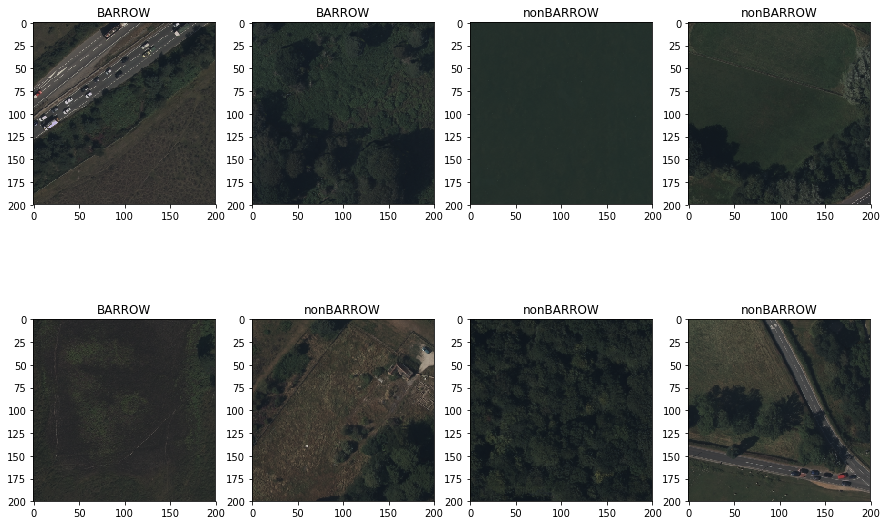

In [67]:
# Plot ad hoc data instances
from jons_image import ImageDataGenerator ## Keras doesn't accept tif files so we've changedredirect the core code and 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob

batch_size = 16

datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_directory(
    'data/train',
    target_size=(200, 200),
    batch_size=batch_size,
    class_mode='binary')

# generate the first batch
(batch_images, batch_labels) = generator.next()

class_labels = [item[0] for item in sorted(generator.class_indices.items(), key=lambda x: x[1])] #get a list of classes
print('Classes are: ',class_labels)

batch_labels = batch_labels.astype(np.int)

# plot images
fig=plt.figure(figsize=(15, 10))
columns = 4
rows = 2
for i in range(1, 9):
    fig.add_subplot(rows, columns, i).set_title(class_labels[batch_labels[i]])
    plt.imshow(batch_images[i]) 

# show the plot
plt.savefig("images/batch-rgb.png")

You can see that accessing the dataset is quite easy. The most important caveat of using the *ImageDataGenerator* comes when we are using it to load the test data - in such a case we need to ensure that no augmentation happens (other than the resizing of inputs through the *target_size* attribute of *flow_from_directory*), and that the shuffle attribute of *flow_from_directory* is False, to ensure that we can compare the true labels and target labels correctly.

## A simple CNN for barrow classification
Now let’s try something a little more challenging and take our larger convolutional network from the experiments
with mnist and apply it to the problem of barrow classification. Firstly we need to setup the data for training (this time using the generator so we don’t have to worry about memory usage), and it would also be sensible to load the
validation data to monitor performance during training, as well as load the test data:

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing import image
from keras.models import Model
from keras.utils import np_utils
from keras import backend as K

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# rescale is a value by which we will multiply the data before any other processing. Our original images 
# consist in RGB coefficients in the 0-255, but such values would be too high for our models to process 
# (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# the number of images that will be processed in a single step
batch_size=32

# the size of the images that we'll learn on - we'll shrink them from the original size for speed
image_size=(200, 200)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

valid_generator = test_datagen.flow_from_directory(
    'data/valid',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

num_classes = len(train_generator.class_indices)

Found 348 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


In [69]:
nb_train_samples = 348
nb_validation_samples = 174

Note that for now we’re not using any data augmentation from the training data, however we’ve structured the code
so that we can easily add it by manipulating the *ImageDataGenerator* that creates the *train_datagen* object.

Now we can add the network definition from part 1. We’ll make a slight change to the previous *larger_model()* function
so that it allows us to specify the input and output sizes, and we’ll also pull out the compile statement as it would be
the same for many model architectures:

In [70]:
def larger_model(input_shape, num_classes):
    # create model
    
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid')) # because we have a 2 class problem (with more you'd want to use softmax)
    return model

# build the model
model = larger_model(train_generator.image_shape, num_classes)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Specifying the input shape using the shape given by the *train_generator.image_shape* allows us to avoid having to worry
about how the backend is storing the images. We’re now in a position to add the code to fit the model. Because this
time we’re loading the data using a generator rather than statically we use the *fit_generator()* method instead of fit:

In [71]:
# Fit the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=10,
    verbose=1)

Epoch 1/10
10/10 [==============================] - 5s - loss: 0.7553 - acc: 0.5000 - val_loss: 0.6904 - val_acc: 0.5500
Epoch 2/10
10/10 [==============================] - 1s - loss: 0.6980 - acc: 0.5090 - val_loss: 0.6913 - val_acc: 0.6127
Epoch 3/10
10/10 [==============================] - 1s - loss: 0.6878 - acc: 0.5684 - val_loss: 0.6956 - val_acc: 0.4648
Epoch 4/10
10/10 [==============================] - 1s - loss: 0.6784 - acc: 0.5567 - val_loss: 0.6573 - val_acc: 0.6549
Epoch 5/10
10/10 [==============================] - 1s - loss: 0.6646 - acc: 0.5924 - val_loss: 0.6786 - val_acc: 0.6127
Epoch 6/10
10/10 [==============================] - 1s - loss: 0.6690 - acc: 0.6914 - val_loss: 0.8186 - val_acc: 0.4859
Epoch 7/10
10/10 [==============================] - 1s - loss: 0.7249 - acc: 0.5481 - val_loss: 0.6870 - val_acc: 0.5000
Epoch 8/10
10/10 [==============================] - 1s - loss: 0.6853 - acc: 0.5466 - val_loss: 0.6995 - val_acc: 0.4789
Epoch 9/10
10/10 [==============

We’ve specified *348 // batch_size steps_per_epoch* to indicate that we want all images (there are 348 training images) to be processed each epoch (each step within an epoch will process a single batch worth of images). The same applies for the *validation_steps*.

Finally, before we try running this model, lets make use of the test data and print a classification report using scikitlearn:

In [72]:
# Final evaluation of the model
# Compute the number of epochs required so we see all data:
test_steps_per_epoch = np.math.ceil(float(test_generator.samples) / test_generator.batch_size)
# perform prediction:
raw_predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# convert predictions from one-hot to indices
predictions = np.argmax(raw_predictions, axis=1)

print("Prediction Distribution: " + str(np.bincount(predictions)))
print("Groundtruth Distribution: " + str(np.bincount(test_generator.classes)))

from sklearn import metrics
#get a list of classes (this basically ensures that the list is in the correct order by index):
class_labels = [item[0] for item in sorted(test_generator.class_indices.items(), key=lambda x: x[1])] #get a list of classes
#print the report
print(metrics.classification_report(test_generator.classes, predictions, target_names=class_labels))

Prediction Distribution: [61]
Groundtruth Distribution: [31 30]
             precision    recall  f1-score   support

     BARROW       0.51      1.00      0.67        31
  nonBARROW       0.00      0.00      0.00        30

avg / total       0.26      0.51      0.34        61



C:\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In this particular case the overall accuracies are a bit mixed; whist the average is high, it is clear that our model
doesnt work well for some classes. Be aware though that we’re using a relatively small set of both training and
validation data, and that there is a very high bias in the class distribution which inevitably could lead to higher
accuracies because of common classes. As we mentioned in the first tutorial, this network architecture isn’t any thing
like one that has won the image classificiation challenges.

    Exercise: Have a play with the above code and explore the effect of patch size and the amount of
    training and validation data.

# Tricks to counter overfitting a network when having a small dataset
Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

<img src="images/overfitting.png" alt="over-fitting" style="width: 55%"/> 

## Data augmentation
These are just a few of the options available (for more, see the documentation). Let's quickly go over what we just wrote:

* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [73]:
# Apply augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        zoom_range=0.5,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    'data/valid',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

test_generator = valid_datagen.flow_from_directory(
    'data/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 348 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


let's visualize the augmentations we made:

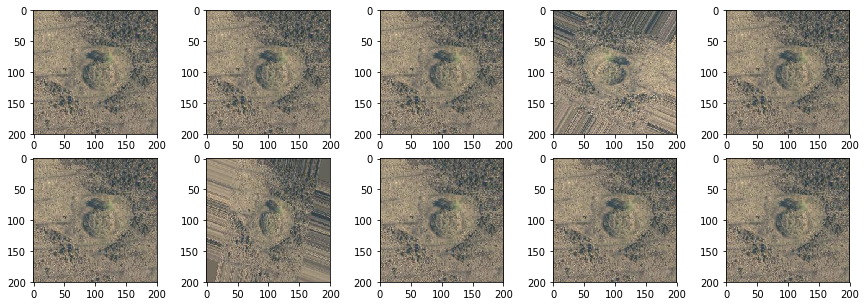

In [74]:
img = image.load_img('data/valid/BARROW/BARROW434130-99380.tif')  # this is a PIL image
x = image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `images/augment/` directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='images/augment', save_prefix='barrow', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
barrow = glob.glob("images/augment/barrow*")

fig=plt.figure(figsize=(15, 5))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = image.load_img(barrow[i])
    img = image.img_to_array(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img/255.)    


It seems like the barrow need to be perfectly in the center for some of these augmentations. Perhaps a wider crop would be better or a smaller zoom.
    Exercise: try different augmentations and think about what augmentations would be best to find barrows

Let's try training with the new image additions:

In [75]:
model = larger_model(train_generator.image_shape, num_classes)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fit the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=10,
    verbose=1)

Epoch 1/10
10/10 [==============================] - 4s - loss: 0.7227 - acc: 0.4906 - val_loss: 0.6953 - val_acc: 0.4562
Epoch 2/10
10/10 [==============================] - 2s - loss: 0.6923 - acc: 0.4961 - val_loss: 0.6509 - val_acc: 0.6127
Epoch 3/10
10/10 [==============================] - 2s - loss: 0.6887 - acc: 0.5626 - val_loss: 0.6938 - val_acc: 0.5775
Epoch 4/10
10/10 [==============================] - 2s - loss: 0.6864 - acc: 0.5861 - val_loss: 0.7150 - val_acc: 0.3873
Epoch 5/10
10/10 [==============================] - 2s - loss: 0.6789 - acc: 0.5838 - val_loss: 0.6805 - val_acc: 0.5775
Epoch 6/10
10/10 [==============================] - 2s - loss: 0.6483 - acc: 0.6666 - val_loss: 0.6437 - val_acc: 0.6338
Epoch 7/10
10/10 [==============================] - 2s - loss: 0.6006 - acc: 0.7352 - val_loss: 0.6474 - val_acc: 0.5845
Epoch 8/10
10/10 [==============================] - 2s - loss: 0.6695 - acc: 0.6287 - val_loss: 0.6171 - val_acc: 0.6127
Epoch 9/10
10/10 [==============

## Improve the network

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated.

To improve your network directly for small dataset you can use weight regularization, such as L1 or L2 regularization, to force the model weights to taker smaller values. Adding the L2 weight decay in the loss encourages the network to learn smaller/less noisy weights and possibly improve generalization.

Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

Finally, there is still some discussion whether shallower networks are better for small datasets: 
* In a Keras tutorial f.chollet claims "...your main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better. There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization...".  https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* At Stanford they teach "Neural Networks with more neurons can express more complicated functions. However, this is both a blessing (since we can learn to classify more complicated data) and a curse (since it is easier to overfit the training data). Overfitting occurs when a model with high capacity fits the noise in the data instead of the (assumed) underlying relationship ... The takeaway is that you should not be using smaller networks because you are afraid of overfitting. Instead, you should use as big of a neural network as your computational budget allows, and use other regularization techniques to control overfitting." http://cs231n.github.io/neural-networks-1/#arch

Both are very interesting concept from influential researchers in the field but it seems that Stanford's few on this is more plausible + the have done the analysis to prove it!

For now we'll stick with adding weight decay on the convolutional layers:

In [76]:
from keras.regularizers import l2

def wd_model(input_shape, num_classes):
    i= 0.000001 
    '''can choose other values like 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0 -- You would apply 
        higher L2 when the examples are more “different”. So we apply a high one which generally works 
        better for me but also needs more epochs to get to a better result...'''
        
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=input_shape, kernel_regularizer=l2(i)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3, 3), kernel_regularizer=l2(i)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3, 3), kernel_regularizer=l2(i)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, kernel_regularizer=l2(i)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=l2(i)))
    model.add(Activation('sigmoid'))
    return model

# build the model
model = wd_model(train_generator.image_shape, num_classes)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [77]:
# Fit the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=15,
    verbose=1)

Epoch 1/15
10/10 [==============================] - 4s - loss: 0.7075 - acc: 0.5125 - val_loss: 0.6857 - val_acc: 0.5634
Epoch 2/15
10/10 [==============================] - 2s - loss: 0.6622 - acc: 0.6092 - val_loss: 0.6283 - val_acc: 0.6197
Epoch 3/15
10/10 [==============================] - 2s - loss: 0.6539 - acc: 0.6674 - val_loss: 0.6091 - val_acc: 0.6056
Epoch 4/15
10/10 [==============================] - 3s - loss: 0.6441 - acc: 0.6344 - val_loss: 0.5983 - val_acc: 0.6338
Epoch 5/15
10/10 [==============================] - 3s - loss: 0.6123 - acc: 0.7065 - val_loss: 0.6296 - val_acc: 0.5634
Epoch 6/15
10/10 [==============================] - 2s - loss: 0.6330 - acc: 0.6455 - val_loss: 0.6073 - val_acc: 0.6056
Epoch 7/15
10/10 [==============================] - 2s - loss: 0.6062 - acc: 0.6976 - val_loss: 0.5707 - val_acc: 0.6549
Epoch 8/15
10/10 [==============================] - 2s - loss: 0.6041 - acc: 0.7258 - val_loss: 0.5868 - val_acc: 0.6831
Epoch 9/15
10/10 [==============

## Using a better network model - transferring and finetuning a pretrained ResNet
Training a network from scratch can be a lot of work. Is there some way we could take an existing network trained on
some data with one set of labels, and adapt it to work on a different data set with different labels? Assuming that the
inputs of the network are equivalent (for example, image with the same number of bands and size), then the answer
is an emphatic yes! This process of “finetuning” a pre-trained network has become common-place as its much
faster an easier than starting from scratch. This approach will also help us better work with the small amount of data
that we have to train with.

Let’s try this in practice - we’ll start by loading a pre-trained network architecture called a Deep Residual Network
(or ResNet for short) that has been trained on the 1000-class ImageNet dataset. The ResNet architecture is very deep
- it has many (in our case 50) convolutional layers and is currently one of the best performing architectures on the
ImageNet challenge. Keras contains code that implements the resnet50 architecture, and automatically downloads
the pre-trained model weights. We’ll start by using this to load the model and test it by classifying an image:

Predicted: [[('n02641379', 'gar', 0.56121415), ('n02514041', 'barracouta', 0.34212956), ('n02640242', 'sturgeon', 0.060597256), ('n02536864', 'coho', 0.03541091), ('n01484850', 'great_white_shark', 0.0004756038)]]


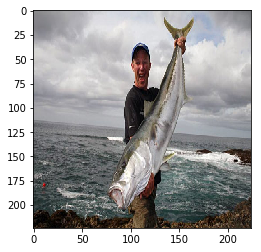

In [78]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np

# (it will take a little longer the first time as the model is downloaded)

model = ResNet50(include_top=True, weights='imagenet')
img_path = 'data/mf.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
plt.imshow(img)
print('Predicted:', decode_predictions(preds))

Indicating that our input image was likely to contain a fish! The *preprocess_input* function is important - it’s
responsible for applying the same operations to out input image as were applied to the images when the network was
trained.

    Exercise: try the model with some of your own images
        
We’re now in a position to start to hack the model structure. Fundamentally we need to first remove the
classification layer at the end of the model and replace it with a new one (with a different number of classes):

In [79]:
def hack_resnet(input_size, num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_size)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(num_classes, activation='sigmoid', name='fc1000')(x) # sigmoid because we have a 2 class problem (with more you'd want to use softmax)

    # this is the model we will train
    newmodel = Model(inputs=base_model.input, outputs=x)

    return newmodel
newmodel = hack_resnet(train_generator.image_shape, num_classes)

In [80]:
from keras import optimizers
newmodel.compile(loss='binary_crossentropy',
    optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy'])
#save model
newmodel.save('hackresnet.h5')

predicted barrow: [[0.46905285 0.30706337]]


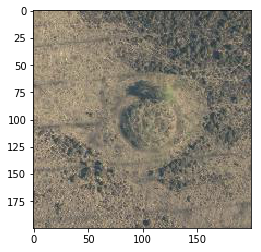

In [81]:
from keras.models import load_model

# load a model
model = load_model('hackresnet.h5')

img_path = 'images/barrow_0_257.jpeg'

img = image.load_img(img_path)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)

print("predicted barrow: "+str(preds))
plt.imshow(img)

The actual process of finetuning involves us now training the model with our own data. This is as simple as
compiling the model and running the *fit* or *fit_generator* methods as before. As the network is already largely trained,
we’ll likely want to use a small learning rate so not to make big changes in weights:

Often we’ll first “freeze” the weights of the already trained layers whilst we learn initial weights for our new layer to
avoid overfitting before training:

In [82]:
# set weights in all but last layer
# to non-trainable (weights will not be updated)
for layer in model.layers[:len(model.layers)-2]:
    layer.trainable = False

In [83]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy'])

If we have lots of training data we could then unlock these layers and perform end-to-end finetuning afterwards.
The Standford CS231n course pages have lots of useful hints on fine-tuning: http://cs231n.github.io/transferlearning/
(http://cs231n.github.io/transfer-learning/)

    Exercise: try finetuning the resnet50 with the barrow data. You’ll need a GPU to do this effectively
    as it’s rather slow! Note that you should set the image_size to be (240, 800) as the resnet has
    minimum size limits on which it can operate. You’ll also need to adjust the input images by
    applying the preprocess_input function - you can modify both ImageDataGenerator constructor calls to
    ImageDataGenerator(preprocessing_function=preprocess_input) to achieve this.

## Extracting features from a model
Sometimes you want to do things that are not so easily accomplished with a deep network. You might want to build
classifiers using very small amounts of data, or you might want a way of finding things in photographs that are in
some way semantically similar, but don’t have exactly the same classes. CNNs can actually help here using a
technique known often called transfer learning (and related to the fine tuning that we just looked at). If we assume
we have a trained network, then by extracting vectors from the layers before the final classifier we should have a
means of achieving these tasks, as the vectors are likely to strongly encode semantic information about the content
of the input image. If we wanted to quickly train new classifiers for new classes, we could for instance just use a
relatively simple linear classifier trained on these vectors. If we wanted to find semantically similar images, we could
just compare the Euclidean distance of these vectors.

Keras makes it pretty easy to get these vector representations. The following code gets a resnet model in which the a
feature vector is computed from the penultimate layer of the network by applying a *global average pooling* operation
over the feature maps:

In [84]:
model = ResNet50(include_top=False,
    weights='imagenet',
    pooling='avg')

With this model, we can use the *predict()* method to extract the features for some inputs. To demonstrate, we can put
the whole thing together and generate a vector from an image

(1, 2048)
[[0.04442348 0.66198117 0.10304552 ... 0.24821588 1.5120101  0.00373608]]


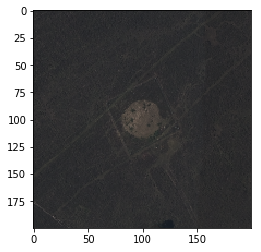

In [85]:
model = ResNet50(include_top=False,
    weights='imagenet',
    pooling='avg')

img_path = 'data\\test\\BARROW\\BARROW439804-104734.tif'
img = image.load_img(img_path, target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = model.predict(x)

plt.imshow(img)
print(features.shape)
print(features)

(Obviously this will be more effective if the network has been trained or fine-tuned on the same kind of data that
we’re extracting features from.)

    Exercise: try generating some features for different patches and calculating the Euclidean
    distances between these features. How do the Euclidean distances compare to your perception of
    similarity between the patches?

    Exercise: Can you train a set of SVMs to learn the boat classes using the features extracted by a
    ResNet? How does the performance compare to the finetuned ResNet? What’s the difference in
    runtime?

# Try working with other Remote Sensor data

We are going to use the DTM 1m data from to be downloaded here. https://we.tl/Ztvq58ZNrp

Found 516 images belonging to 2 classes.
Classes are:  ['BARROW', 'nonBARROW']


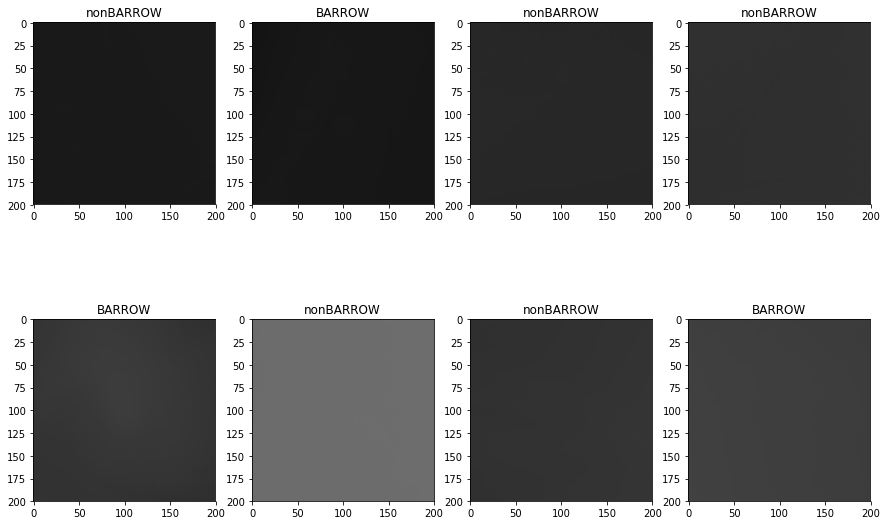

In [86]:
batch_size = 16

datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_directory(
    'data\\DTM1m\\train',
    target_size=(200, 200),
    batch_size=batch_size,
    class_mode='binary')

# generate the first batch
(batch_images, batch_labels) = generator.next()

class_labels = [item[0] for item in sorted(generator.class_indices.items(), key=lambda x: x[1])] #get a list of classes
print('Classes are: ',class_labels)

batch_labels = batch_labels.astype(np.int)

# plot images
fig=plt.figure(figsize=(15, 10))
columns = 4
rows = 2
for i in range(1, 9):
    fig.add_subplot(rows, columns, i).set_title(class_labels[batch_labels[i]])
    plt.imshow(batch_images[i]) 

# show the plot
plt.savefig("images\\batch-DTM1m.png")

In [87]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# the number of images that will be processed in a single step
batch_size=32

# the size of the images that we'll learn on - we'll shrink them from the original size for speed
image_size=(200, 200)

train_generator = train_datagen.flow_from_directory(
    'data\\DTM1m\\train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

valid_generator = test_datagen.flow_from_directory(
    'data\\DTM1m\\valid',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    'data\\DTM1m\\test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

num_classes = len(train_generator.class_indices)

Found 516 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [88]:
nb_train_samples = 516
nb_validation_samples = 300

In [89]:
# build the model
model = larger_model(train_generator.image_shape, num_classes)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fit the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=10,
    verbose=1)

Epoch 1/10
16/16 [==============================] - 6s - loss: 0.7097 - acc: 0.5293 - val_loss: 0.6682 - val_acc: 0.5972
Epoch 2/10
16/16 [==============================] - 2s - loss: 0.6675 - acc: 0.5689 - val_loss: 0.6760 - val_acc: 0.6736
Epoch 3/10
16/16 [==============================] - 2s - loss: 0.6688 - acc: 0.5675 - val_loss: 0.7195 - val_acc: 0.4792
Epoch 4/10
16/16 [==============================] - 2s - loss: 0.6614 - acc: 0.6156 - val_loss: 0.8600 - val_acc: 0.4792
Epoch 5/10
16/16 [==============================] - 2s - loss: 0.6437 - acc: 0.6265 - val_loss: 0.8266 - val_acc: 0.4792
Epoch 6/10
16/16 [==============================] - 2s - loss: 0.6568 - acc: 0.6156 - val_loss: 0.9901 - val_acc: 0.4792
Epoch 7/10
16/16 [==============================] - 2s - loss: 0.6368 - acc: 0.6324 - val_loss: 0.9343 - val_acc: 0.4792
Epoch 8/10
16/16 [==============================] - 2s - loss: 0.6497 - acc: 0.6069 - val_loss: 0.9714 - val_acc: 0.4792
Epoch 9/10
16/16 [==============

we can see here that we are overfitting. 
* do you have an idea why?

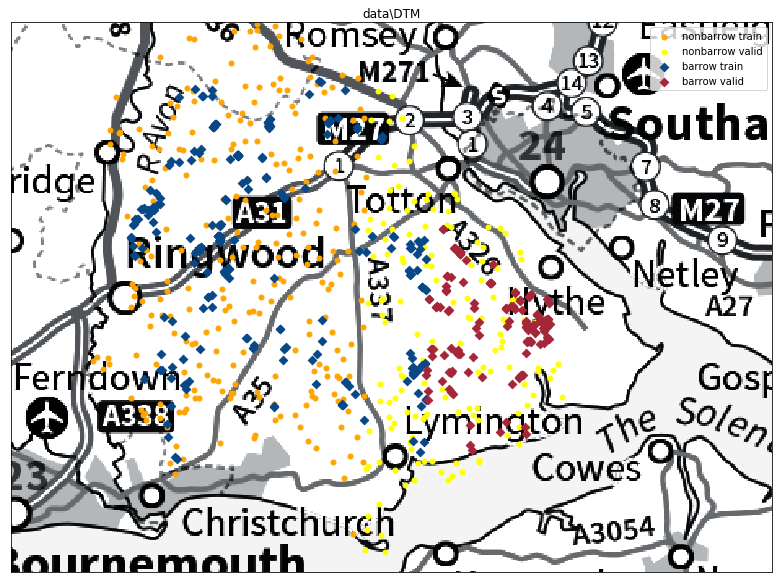

In [100]:
from os import listdir
import PIL

def location(files):
    coords = collections.OrderedDict()
    inProj = pyproj.Proj(init='epsg:27700')
    outProj = pyproj.Proj(init='epsg:4326')  # unfortunately basemap doesn't accept british nat grid so WGS 84 is used instead
    
    for num in files:
        x = num.partition('ROW')[-1].rpartition('-')[0]
        y = num.partition('-')[-1].rpartition('.tif')[0]
        x2,y2 = pyproj.transform(inProj,outProj,x,y)
        coords[num] = (float(x2),float(y2))
    coordsArray = np.fromiter(coords.values(),dtype=[('x','d'),('y','d')])
    return coordsArray

import glob
import collections
import mpl_toolkits
from mpl_toolkits.basemap import Basemap, pyproj

def visualiseLocations(folder, targetObjects):
    barrow_train = location(listdir('{}\\train\\{}\\'.format(folder,targetObjects)))                  
    barrow_valid = location(listdir('{}\\valid\\{}\\'.format(folder,targetObjects)))
    nonbarrow_train = location(listdir('{}\\train\\non{}\\'.format(folder,targetObjects))) 
    nonbarrow_valid = location(listdir('{}\\valid\\non{}\\'.format(folder,targetObjects)))  

    OSnewforest = PIL.Image.open('images\\newforestBASE.tif')
    f = plt.figure(figsize=(30,30))
    f.add_subplot(121)

    newforest = Basemap(projection='merc', llcrnrlon=-1.8739992478,llcrnrlat=50.6934780793,urcrnrlon=-1.20751395668,urcrnrlat=50.997632953)
    newforest.imshow(OSnewforest,origin='upper')

    # scatter image data    
    newforest.scatter(nonbarrow_train['x'], nonbarrow_train['y'],marker='.',s=100,color='orange', label='nonbarrow train',latlon=True)
    newforest.scatter(nonbarrow_valid['x'], nonbarrow_valid['y'],marker='.',s=100,color='yellow', label='nonbarrow valid',latlon=True)

    newforest.scatter(barrow_train['x'], barrow_train['y'],marker='D',color='#084887', label='barrow train',latlon=True)
    newforest.scatter(barrow_valid['x'], barrow_valid['y'],marker='D',color='#a62639', label='barrow valid',latlon=True)


    plt.title(folder[:-2])
    plt.legend()
    plt.show
visualiseLocations('data\\DTM1m', 'BARROW')


<!-- <img src="images/dtm-barrows.png" alt="dtm-barrows" style="width: 55%"/> -->
The training data is on the west of the New Forest and the validation data in east have a totally diffent average elevation. 
* try normalising the data with the means
* apply the below filter on train and validation generators


In [ ]:
def filter(iter):
    for batch in iter:
        print(batch[0][:,:,:,0].flatten().mean()
        yield batch[0] - means, batch[1]